CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [5]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/'
DATA_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/data/'
MODEL_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/'
LOG_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/log/'
WEIGHT_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/weight/'

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((30, 512, 512, 1), (30, 512, 512, 1), (30, 512, 512, 1))

In [6]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((24, 512, 512, 1), (3, 512, 512, 1), (24, 512, 512, 1), (3, 512, 512, 1))

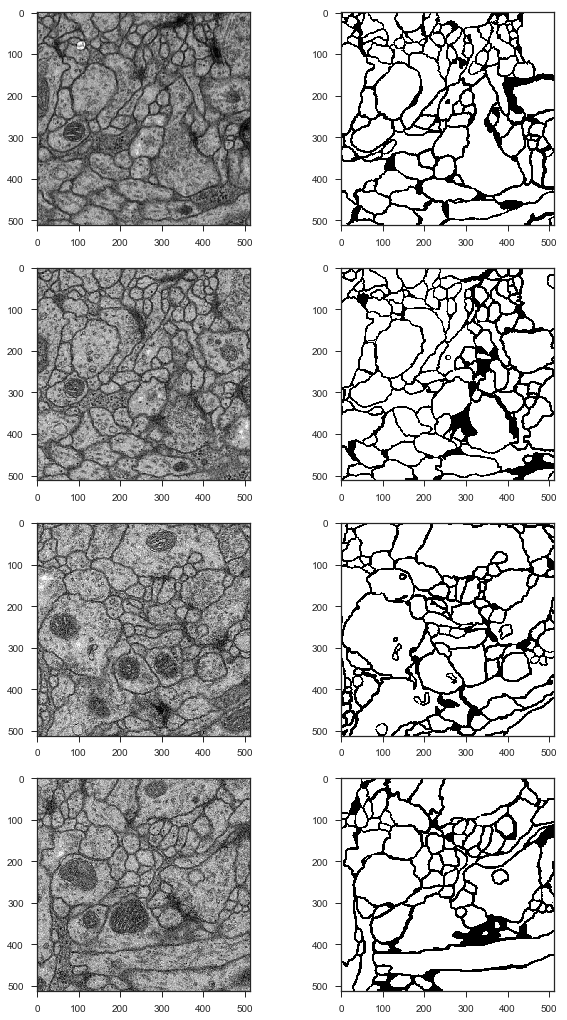

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 18))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [10]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from Loss_Functions import cross_entropy_balanced, pixel_error
from ResNet_UNet_Side_Fuse import u_res_side_fuse_v3
from Loss_Functions import dice_coef

In [11]:
model_unet_side_fuse = u_res_side_fuse_v3(input_shape=(512, 512, 1))
model_unet_side_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 160         pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [12]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.5, patience=5, verbose=1, 
                             min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_RES_Fuse_v3', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=3e-2, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=4, epochs=100, callbacks=callback_list, verbose=2)

Train on 24 samples, validate on 3 samples


Epoch 1/100


 - 33s - loss: 1.4025 - o1_loss: 0.2323 - o2_loss: 0.2323 - o3_loss: 0.2350 - o4_loss: 0.2275 - o5_loss: 0.2279 - ofuse_loss: 0.2475 - ofuse_dice_coef: 0.2843 - ofuse_pixel_error: 0.5103 - val_loss: 1.7690 - val_o1_loss: 0.2594 - val_o2_loss: 0.2597 - val_o3_loss: 0.2973 - val_o4_loss: 0.3412 - val_o5_loss: 0.2967 - val_ofuse_loss: 0.3147 - val_ofuse_dice_coef: 0.3061 - val_ofuse_pixel_error: 0.5093



Epoch 00001: val_loss improved from inf to 1.76902, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 2/100


 - 5s - loss: 1.3261 - o1_loss: 0.2318 - o2_loss: 0.2314 - o3_loss: 0.2317 - o4_loss: 0.2109 - o5_loss: 0.1684 - ofuse_loss: 0.2518 - ofuse_dice_coef: 0.2766 - ofuse_pixel_error: 0.6044 - val_loss: 5.8139 - val_o1_loss: 0.4197 - val_o2_loss: 0.3087 - val_o3_loss: 0.8015 - val_o4_loss: 1.4587 - val_o5_loss: 1.7906 - val_ofuse_loss: 1.0347 - val_ofuse_dice_coef: 0.2790 - val_ofuse_pixel_error: 0.4134



Epoch 00002: val_loss did not improve
Epoch 3/100


 - 5s - loss: 1.2947 - o1_loss: 0.2310 - o2_loss: 0.2292 - o3_loss: 0.2303 - o4_loss: 0.2000 - o5_loss: 0.1471 - ofuse_loss: 0.2571 - ofuse_dice_coef: 0.2728 - ofuse_pixel_error: 0.6421 - val_loss: 3.2793 - val_o1_loss: 0.4609 - val_o2_loss: 0.3412 - val_o3_loss: 0.3864 - val_o4_loss: 0.6298 - val_o5_loss: 0.8843 - val_ofuse_loss: 0.5768 - val_ofuse_dice_coef: 0.2817 - val_ofuse_pixel_error: 0.4172



Epoch 00003: val_loss did not improve
Epoch 4/100


 - 5s - loss: 1.2636 - o1_loss: 0.2264 - o2_loss: 0.2236 - o3_loss: 0.2291 - o4_loss: 0.1944 - o5_loss: 0.1381 - ofuse_loss: 0.2521 - ofuse_dice_coef: 0.2830 - ofuse_pixel_error: 0.6046 - val_loss: 3.1351 - val_o1_loss: 0.6853 - val_o2_loss: 0.7379 - val_o3_loss: 0.3034 - val_o4_loss: 0.3272 - val_o5_loss: 0.4294 - val_ofuse_loss: 0.6519 - val_ofuse_dice_coef: 0.2469 - val_ofuse_pixel_error: 0.3521



Epoch 00004: val_loss did not improve
Epoch 5/100


 - 6s - loss: 1.2174 - o1_loss: 0.2169 - o2_loss: 0.2154 - o3_loss: 0.2275 - o4_loss: 0.1826 - o5_loss: 0.1299 - ofuse_loss: 0.2452 - ofuse_dice_coef: 0.3032 - ofuse_pixel_error: 0.5318 - val_loss: 3.3958 - val_o1_loss: 0.8571 - val_o2_loss: 0.6645 - val_o3_loss: 0.3005 - val_o4_loss: 0.4513 - val_o5_loss: 0.4009 - val_ofuse_loss: 0.7216 - val_ofuse_dice_coef: 0.2176 - val_ofuse_pixel_error: 0.3587



Epoch 00005: val_loss did not improve
Epoch 6/100


 - 5s - loss: 1.1593 - o1_loss: 0.2056 - o2_loss: 0.2050 - o3_loss: 0.2252 - o4_loss: 0.1714 - o5_loss: 0.1183 - ofuse_loss: 0.2338 - ofuse_dice_coef: 0.3276 - ofuse_pixel_error: 0.4720 - val_loss: 4.0917 - val_o1_loss: 1.0433 - val_o2_loss: 0.6430 - val_o3_loss: 0.2714 - val_o4_loss: 0.4262 - val_o5_loss: 0.8137 - val_ofuse_loss: 0.8942 - val_ofuse_dice_coef: 0.2036 - val_ofuse_pixel_error: 0.3219



Epoch 00006: val_loss did not improve
Epoch 7/100


 - 5s - loss: 1.0993 - o1_loss: 0.1941 - o2_loss: 0.1939 - o3_loss: 0.2218 - o4_loss: 0.1642 - o5_loss: 0.1093 - ofuse_loss: 0.2160 - ofuse_dice_coef: 0.3594 - ofuse_pixel_error: 0.4128 - val_loss: 2.9699 - val_o1_loss: 0.7065 - val_o2_loss: 0.4046 - val_o3_loss: 0.2797 - val_o4_loss: 0.4562 - val_o5_loss: 0.5640 - val_ofuse_loss: 0.5589 - val_ofuse_dice_coef: 0.2832 - val_ofuse_pixel_error: 0.3657



Epoch 00007: val_loss did not improve
Epoch 8/100


 - 5s - loss: 1.0413 - o1_loss: 0.1844 - o2_loss: 0.1835 - o3_loss: 0.2165 - o4_loss: 0.1498 - o5_loss: 0.1020 - ofuse_loss: 0.2051 - ofuse_dice_coef: 0.3851 - ofuse_pixel_error: 0.3741 - val_loss: 3.2663 - val_o1_loss: 0.6776 - val_o2_loss: 0.6321 - val_o3_loss: 0.2915 - val_o4_loss: 0.6062 - val_o5_loss: 0.5575 - val_ofuse_loss: 0.5015 - val_ofuse_dice_coef: 0.3071 - val_ofuse_pixel_error: 0.3323



Epoch 00008: val_loss did not improve
Epoch 9/100


 - 5s - loss: 0.9879 - o1_loss: 0.1782 - o2_loss: 0.1743 - o3_loss: 0.2082 - o4_loss: 0.1394 - o5_loss: 0.0960 - ofuse_loss: 0.1919 - ofuse_dice_coef: 0.4197 - ofuse_pixel_error: 0.3408 - val_loss: 1.7648 - val_o1_loss: 0.3228 - val_o2_loss: 0.2693 - val_o3_loss: 0.2514 - val_o4_loss: 0.2791 - val_o5_loss: 0.3272 - val_ofuse_loss: 0.3150 - val_ofuse_dice_coef: 0.3659 - val_ofuse_pixel_error: 0.3894



Epoch 00009: val_loss improved from 1.76902 to 1.76483, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 10/100


 - 5s - loss: 0.9318 - o1_loss: 0.1700 - o2_loss: 0.1642 - o3_loss: 0.1972 - o4_loss: 0.1297 - o5_loss: 0.0921 - ofuse_loss: 0.1785 - ofuse_dice_coef: 0.4483 - ofuse_pixel_error: 0.3022 - val_loss: 1.7820 - val_o1_loss: 0.3327 - val_o2_loss: 0.2608 - val_o3_loss: 0.2368 - val_o4_loss: 0.2110 - val_o5_loss: 0.4146 - val_ofuse_loss: 0.3262 - val_ofuse_dice_coef: 0.4120 - val_ofuse_pixel_error: 0.3234



Epoch 00010: val_loss did not improve
Epoch 11/100


 - 5s - loss: 0.8712 - o1_loss: 0.1629 - o2_loss: 0.1550 - o3_loss: 0.1842 - o4_loss: 0.1192 - o5_loss: 0.0853 - ofuse_loss: 0.1646 - ofuse_dice_coef: 0.4815 - ofuse_pixel_error: 0.2735 - val_loss: 1.5674 - val_o1_loss: 0.3415 - val_o2_loss: 0.2365 - val_o3_loss: 0.2246 - val_o4_loss: 0.2052 - val_o5_loss: 0.2349 - val_ofuse_loss: 0.3247 - val_ofuse_dice_coef: 0.4372 - val_ofuse_pixel_error: 0.3007



Epoch 00011: val_loss improved from 1.76483 to 1.56741, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 12/100


 - 5s - loss: 0.8145 - o1_loss: 0.1571 - o2_loss: 0.1467 - o3_loss: 0.1697 - o4_loss: 0.1087 - o5_loss: 0.0796 - ofuse_loss: 0.1526 - ofuse_dice_coef: 0.5148 - ofuse_pixel_error: 0.2459 - val_loss: 1.2247 - val_o1_loss: 0.2264 - val_o2_loss: 0.2102 - val_o3_loss: 0.2075 - val_o4_loss: 0.1682 - val_o5_loss: 0.1912 - val_ofuse_loss: 0.2212 - val_ofuse_dice_coef: 0.4895 - val_ofuse_pixel_error: 0.2858



Epoch 00012: val_loss improved from 1.56741 to 1.22465, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 13/100


 - 5s - loss: 0.7665 - o1_loss: 0.1528 - o2_loss: 0.1397 - o3_loss: 0.1557 - o4_loss: 0.1015 - o5_loss: 0.0764 - ofuse_loss: 0.1404 - ofuse_dice_coef: 0.5458 - ofuse_pixel_error: 0.2217 - val_loss: 1.1804 - val_o1_loss: 0.2294 - val_o2_loss: 0.1995 - val_o3_loss: 0.1949 - val_o4_loss: 0.1723 - val_o5_loss: 0.1648 - val_ofuse_loss: 0.2195 - val_ofuse_dice_coef: 0.5036 - val_ofuse_pixel_error: 0.2598



Epoch 00013: val_loss improved from 1.22465 to 1.18041, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 14/100


 - 5s - loss: 0.7272 - o1_loss: 0.1486 - o2_loss: 0.1342 - o3_loss: 0.1428 - o4_loss: 0.0957 - o5_loss: 0.0743 - ofuse_loss: 0.1316 - ofuse_dice_coef: 0.5763 - ofuse_pixel_error: 0.2045 - val_loss: 1.2300 - val_o1_loss: 0.2606 - val_o2_loss: 0.2052 - val_o3_loss: 0.1948 - val_o4_loss: 0.1627 - val_o5_loss: 0.1652 - val_ofuse_loss: 0.2414 - val_ofuse_dice_coef: 0.4952 - val_ofuse_pixel_error: 0.2481



Epoch 00014: val_loss did not improve
Epoch 15/100


 - 5s - loss: 0.6870 - o1_loss: 0.1461 - o2_loss: 0.1283 - o3_loss: 0.1314 - o4_loss: 0.0897 - o5_loss: 0.0698 - ofuse_loss: 0.1216 - ofuse_dice_coef: 0.5964 - ofuse_pixel_error: 0.1887 - val_loss: 1.1892 - val_o1_loss: 0.2437 - val_o2_loss: 0.1997 - val_o3_loss: 0.1854 - val_o4_loss: 0.1774 - val_o5_loss: 0.1612 - val_ofuse_loss: 0.2217 - val_ofuse_dice_coef: 0.5224 - val_ofuse_pixel_error: 0.2407



Epoch 00015: val_loss did not improve
Epoch 16/100


 - 5s - loss: 0.6691 - o1_loss: 0.1441 - o2_loss: 0.1245 - o3_loss: 0.1233 - o4_loss: 0.0875 - o5_loss: 0.0724 - ofuse_loss: 0.1173 - ofuse_dice_coef: 0.6190 - ofuse_pixel_error: 0.1770 - val_loss: 1.1315 - val_o1_loss: 0.2266 - val_o2_loss: 0.1965 - val_o3_loss: 0.1828 - val_o4_loss: 0.1557 - val_o5_loss: 0.1615 - val_ofuse_loss: 0.2085 - val_ofuse_dice_coef: 0.5342 - val_ofuse_pixel_error: 0.2325



Epoch 00016: val_loss improved from 1.18041 to 1.13153, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 17/100


 - 5s - loss: 0.6315 - o1_loss: 0.1418 - o2_loss: 0.1193 - o3_loss: 0.1137 - o4_loss: 0.0818 - o5_loss: 0.0667 - ofuse_loss: 0.1082 - ofuse_dice_coef: 0.6346 - ofuse_pixel_error: 0.1662 - val_loss: 1.0869 - val_o1_loss: 0.2155 - val_o2_loss: 0.1975 - val_o3_loss: 0.1737 - val_o4_loss: 0.1585 - val_o5_loss: 0.1575 - val_ofuse_loss: 0.1843 - val_ofuse_dice_coef: 0.5447 - val_ofuse_pixel_error: 0.2534



Epoch 00017: val_loss improved from 1.13153 to 1.08693, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 18/100


 - 5s - loss: 0.6181 - o1_loss: 0.1400 - o2_loss: 0.1164 - o3_loss: 0.1080 - o4_loss: 0.0803 - o5_loss: 0.0672 - ofuse_loss: 0.1063 - ofuse_dice_coef: 0.6529 - ofuse_pixel_error: 0.1607 - val_loss: 1.1092 - val_o1_loss: 0.2138 - val_o2_loss: 0.1912 - val_o3_loss: 0.1900 - val_o4_loss: 0.1516 - val_o5_loss: 0.1648 - val_ofuse_loss: 0.1978 - val_ofuse_dice_coef: 0.5427 - val_ofuse_pixel_error: 0.2087



Epoch 00018: val_loss did not improve
Epoch 19/100


 - 5s - loss: 0.5870 - o1_loss: 0.1369 - o2_loss: 0.1108 - o3_loss: 0.1024 - o4_loss: 0.0742 - o5_loss: 0.0635 - ofuse_loss: 0.0992 - ofuse_dice_coef: 0.6638 - ofuse_pixel_error: 0.1511 - val_loss: 1.2240 - val_o1_loss: 0.2264 - val_o2_loss: 0.1933 - val_o3_loss: 0.1882 - val_o4_loss: 0.1769 - val_o5_loss: 0.2083 - val_ofuse_loss: 0.2309 - val_ofuse_dice_coef: 0.5854 - val_ofuse_pixel_error: 0.2352



Epoch 00019: val_loss did not improve
Epoch 20/100


 - 5s - loss: 0.5678 - o1_loss: 0.1357 - o2_loss: 0.1067 - o3_loss: 0.0958 - o4_loss: 0.0721 - o5_loss: 0.0616 - ofuse_loss: 0.0959 - ofuse_dice_coef: 0.6779 - ofuse_pixel_error: 0.1454 - val_loss: 1.0203 - val_o1_loss: 0.2100 - val_o2_loss: 0.1838 - val_o3_loss: 0.1661 - val_o4_loss: 0.1361 - val_o5_loss: 0.1424 - val_ofuse_loss: 0.1820 - val_ofuse_dice_coef: 0.5900 - val_ofuse_pixel_error: 0.1967



Epoch 00020: val_loss improved from 1.08693 to 1.02033, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 21/100


 - 5s - loss: 0.5566 - o1_loss: 0.1348 - o2_loss: 0.1042 - o3_loss: 0.0927 - o4_loss: 0.0707 - o5_loss: 0.0615 - ofuse_loss: 0.0926 - ofuse_dice_coef: 0.6881 - ofuse_pixel_error: 0.1381 - val_loss: 1.0252 - val_o1_loss: 0.2093 - val_o2_loss: 0.1818 - val_o3_loss: 0.1714 - val_o4_loss: 0.1376 - val_o5_loss: 0.1426 - val_ofuse_loss: 0.1825 - val_ofuse_dice_coef: 0.5793 - val_ofuse_pixel_error: 0.1839



Epoch 00021: val_loss did not improve
Epoch 22/100


 - 5s - loss: 0.5355 - o1_loss: 0.1326 - o2_loss: 0.1001 - o3_loss: 0.0883 - o4_loss: 0.0673 - o5_loss: 0.0588 - ofuse_loss: 0.0884 - ofuse_dice_coef: 0.6993 - ofuse_pixel_error: 0.1347 - val_loss: 1.0153 - val_o1_loss: 0.2116 - val_o2_loss: 0.1783 - val_o3_loss: 0.1611 - val_o4_loss: 0.1363 - val_o5_loss: 0.1438 - val_ofuse_loss: 0.1843 - val_ofuse_dice_coef: 0.5971 - val_ofuse_pixel_error: 0.2009



Epoch 00022: val_loss improved from 1.02033 to 1.01526, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 23/100


 - 5s - loss: 0.5275 - o1_loss: 0.1325 - o2_loss: 0.0978 - o3_loss: 0.0859 - o4_loss: 0.0665 - o5_loss: 0.0588 - ofuse_loss: 0.0860 - ofuse_dice_coef: 0.7101 - ofuse_pixel_error: 0.1251 - val_loss: 1.2791 - val_o1_loss: 0.2343 - val_o2_loss: 0.2183 - val_o3_loss: 0.1962 - val_o4_loss: 0.1817 - val_o5_loss: 0.2096 - val_ofuse_loss: 0.2390 - val_ofuse_dice_coef: 0.5533 - val_ofuse_pixel_error: 0.1865



Epoch 00023: val_loss did not improve
Epoch 24/100


 - 5s - loss: 0.5120 - o1_loss: 0.1309 - o2_loss: 0.0941 - o3_loss: 0.0827 - o4_loss: 0.0641 - o5_loss: 0.0576 - ofuse_loss: 0.0827 - ofuse_dice_coef: 0.7154 - ofuse_pixel_error: 0.1255 - val_loss: 1.1675 - val_o1_loss: 0.2437 - val_o2_loss: 0.2044 - val_o3_loss: 0.1701 - val_o4_loss: 0.1559 - val_o5_loss: 0.1654 - val_ofuse_loss: 0.2280 - val_ofuse_dice_coef: 0.5848 - val_ofuse_pixel_error: 0.2073



Epoch 00024: val_loss did not improve
Epoch 25/100


 - 5s - loss: 0.4986 - o1_loss: 0.1293 - o2_loss: 0.0912 - o3_loss: 0.0794 - o4_loss: 0.0626 - o5_loss: 0.0556 - ofuse_loss: 0.0805 - ofuse_dice_coef: 0.7251 - ofuse_pixel_error: 0.1220 - val_loss: 1.0747 - val_o1_loss: 0.2152 - val_o2_loss: 0.1893 - val_o3_loss: 0.1665 - val_o4_loss: 0.1479 - val_o5_loss: 0.1653 - val_ofuse_loss: 0.1905 - val_ofuse_dice_coef: 0.6008 - val_ofuse_pixel_error: 0.1708



Epoch 00025: val_loss did not improve
Epoch 26/100


 - 5s - loss: 0.4972 - o1_loss: 0.1292 - o2_loss: 0.0897 - o3_loss: 0.0791 - o4_loss: 0.0627 - o5_loss: 0.0573 - ofuse_loss: 0.0792 - ofuse_dice_coef: 0.7314 - ofuse_pixel_error: 0.1152 - val_loss: 1.0486 - val_o1_loss: 0.2082 - val_o2_loss: 0.1802 - val_o3_loss: 0.1600 - val_o4_loss: 0.1524 - val_o5_loss: 0.1632 - val_ofuse_loss: 0.1845 - val_ofuse_dice_coef: 0.6172 - val_ofuse_pixel_error: 0.1981



Epoch 00026: val_loss did not improve
Epoch 27/100


 - 5s - loss: 0.4875 - o1_loss: 0.1290 - o2_loss: 0.0879 - o3_loss: 0.0768 - o4_loss: 0.0607 - o5_loss: 0.0559 - ofuse_loss: 0.0773 - ofuse_dice_coef: 0.7342 - ofuse_pixel_error: 0.1167 - val_loss: 1.0908 - val_o1_loss: 0.2125 - val_o2_loss: 0.1934 - val_o3_loss: 0.1638 - val_o4_loss: 0.1515 - val_o5_loss: 0.1736 - val_ofuse_loss: 0.1960 - val_ofuse_dice_coef: 0.6259 - val_ofuse_pixel_error: 0.1821



Epoch 00027: val_loss did not improve
Epoch 28/100


 - 5s - loss: 0.4711 - o1_loss: 0.1271 - o2_loss: 0.0848 - o3_loss: 0.0733 - o4_loss: 0.0587 - o5_loss: 0.0536 - ofuse_loss: 0.0737 - ofuse_dice_coef: 0.7465 - ofuse_pixel_error: 0.1096 - val_loss: 1.0216 - val_o1_loss: 0.2057 - val_o2_loss: 0.1764 - val_o3_loss: 0.1548 - val_o4_loss: 0.1470 - val_o5_loss: 0.1671 - val_ofuse_loss: 0.1707 - val_ofuse_dice_coef: 0.6254 - val_ofuse_pixel_error: 0.1935



Epoch 00028: val_loss did not improve
Epoch 29/100


 - 5s - loss: 0.4588 - o1_loss: 0.1259 - o2_loss: 0.0822 - o3_loss: 0.0711 - o4_loss: 0.0568 - o5_loss: 0.0517 - ofuse_loss: 0.0710 - ofuse_dice_coef: 0.7513 - ofuse_pixel_error: 0.1056 - val_loss: 1.0587 - val_o1_loss: 0.2036 - val_o2_loss: 0.1841 - val_o3_loss: 0.1631 - val_o4_loss: 0.1500 - val_o5_loss: 0.1774 - val_ofuse_loss: 0.1805 - val_ofuse_dice_coef: 0.6281 - val_ofuse_pixel_error: 0.1738



Epoch 00029: val_loss did not improve
Epoch 30/100


 - 5s - loss: 0.4538 - o1_loss: 0.1253 - o2_loss: 0.0806 - o3_loss: 0.0700 - o4_loss: 0.0558 - o5_loss: 0.0518 - ofuse_loss: 0.0703 - ofuse_dice_coef: 0.7551 - ofuse_pixel_error: 0.1058 - val_loss: 0.9344 - val_o1_loss: 0.1987 - val_o2_loss: 0.1636 - val_o3_loss: 0.1432 - val_o4_loss: 0.1305 - val_o5_loss: 0.1426 - val_ofuse_loss: 0.1560 - val_ofuse_dice_coef: 0.6467 - val_ofuse_pixel_error: 0.1809



Epoch 00030: val_loss improved from 1.01526 to 0.93445, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 31/100


 - 5s - loss: 0.4414 - o1_loss: 0.1242 - o2_loss: 0.0781 - o3_loss: 0.0674 - o4_loss: 0.0543 - o5_loss: 0.0503 - ofuse_loss: 0.0671 - ofuse_dice_coef: 0.7649 - ofuse_pixel_error: 0.0996 - val_loss: 1.0273 - val_o1_loss: 0.2065 - val_o2_loss: 0.1794 - val_o3_loss: 0.1505 - val_o4_loss: 0.1468 - val_o5_loss: 0.1640 - val_ofuse_loss: 0.1801 - val_ofuse_dice_coef: 0.6518 - val_ofuse_pixel_error: 0.1691



Epoch 00031: val_loss did not improve
Epoch 32/100


 - 5s - loss: 0.4293 - o1_loss: 0.1233 - o2_loss: 0.0760 - o3_loss: 0.0648 - o4_loss: 0.0527 - o5_loss: 0.0484 - ofuse_loss: 0.0642 - ofuse_dice_coef: 0.7715 - ofuse_pixel_error: 0.0956 - val_loss: 0.9727 - val_o1_loss: 0.2008 - val_o2_loss: 0.1671 - val_o3_loss: 0.1462 - val_o4_loss: 0.1407 - val_o5_loss: 0.1499 - val_ofuse_loss: 0.1681 - val_ofuse_dice_coef: 0.6547 - val_ofuse_pixel_error: 0.1859



Epoch 00032: val_loss did not improve
Epoch 33/100


 - 5s - loss: 0.4346 - o1_loss: 0.1237 - o2_loss: 0.0760 - o3_loss: 0.0653 - o4_loss: 0.0532 - o5_loss: 0.0503 - ofuse_loss: 0.0661 - ofuse_dice_coef: 0.7750 - ofuse_pixel_error: 0.0956 - val_loss: 1.0267 - val_o1_loss: 0.1985 - val_o2_loss: 0.1775 - val_o3_loss: 0.1547 - val_o4_loss: 0.1487 - val_o5_loss: 0.1741 - val_ofuse_loss: 0.1732 - val_ofuse_dice_coef: 0.6568 - val_ofuse_pixel_error: 0.1571



Epoch 00033: val_loss did not improve
Epoch 34/100


 - 5s - loss: 0.4285 - o1_loss: 0.1232 - o2_loss: 0.0746 - o3_loss: 0.0643 - o4_loss: 0.0527 - o5_loss: 0.0498 - ofuse_loss: 0.0638 - ofuse_dice_coef: 0.7716 - ofuse_pixel_error: 0.0973 - val_loss: 1.0565 - val_o1_loss: 0.2037 - val_o2_loss: 0.1791 - val_o3_loss: 0.1553 - val_o4_loss: 0.1566 - val_o5_loss: 0.1755 - val_ofuse_loss: 0.1863 - val_ofuse_dice_coef: 0.6693 - val_ofuse_pixel_error: 0.1838



Epoch 00034: val_loss did not improve
Epoch 35/100


 - 5s - loss: 0.4170 - o1_loss: 0.1220 - o2_loss: 0.0726 - o3_loss: 0.0620 - o4_loss: 0.0509 - o5_loss: 0.0480 - ofuse_loss: 0.0614 - ofuse_dice_coef: 0.7849 - ofuse_pixel_error: 0.0895 - val_loss: 1.0007 - val_o1_loss: 0.2025 - val_o2_loss: 0.1731 - val_o3_loss: 0.1478 - val_o4_loss: 0.1419 - val_o5_loss: 0.1617 - val_ofuse_loss: 0.1736 - val_ofuse_dice_coef: 0.6734 - val_ofuse_pixel_error: 0.1631



Epoch 00035: val_loss did not improve
Epoch 36/100


 - 5s - loss: 0.4099 - o1_loss: 0.1220 - o2_loss: 0.0714 - o3_loss: 0.0597 - o4_loss: 0.0500 - o5_loss: 0.0470 - ofuse_loss: 0.0598 - ofuse_dice_coef: 0.7860 - ofuse_pixel_error: 0.0889 - val_loss: 0.9569 - val_o1_loss: 0.1992 - val_o2_loss: 0.1652 - val_o3_loss: 0.1442 - val_o4_loss: 0.1348 - val_o5_loss: 0.1505 - val_ofuse_loss: 0.1629 - val_ofuse_dice_coef: 0.6751 - val_ofuse_pixel_error: 0.1626



Epoch 00036: val_loss did not improve
Epoch 37/100


 - 5s - loss: 0.4004 - o1_loss: 0.1210 - o2_loss: 0.0698 - o3_loss: 0.0579 - o4_loss: 0.0480 - o5_loss: 0.0455 - ofuse_loss: 0.0580 - ofuse_dice_coef: 0.7931 - ofuse_pixel_error: 0.0866 - val_loss: 1.0738 - val_o1_loss: 0.2080 - val_o2_loss: 0.1911 - val_o3_loss: 0.1562 - val_o4_loss: 0.1533 - val_o5_loss: 0.1747 - val_ofuse_loss: 0.1906 - val_ofuse_dice_coef: 0.6789 - val_ofuse_pixel_error: 0.1457



Epoch 00037: val_loss did not improve
Epoch 38/100


 - 5s - loss: 0.3963 - o1_loss: 0.1206 - o2_loss: 0.0688 - o3_loss: 0.0577 - o4_loss: 0.0477 - o5_loss: 0.0451 - ofuse_loss: 0.0565 - ofuse_dice_coef: 0.7958 - ofuse_pixel_error: 0.0842 - val_loss: 1.0040 - val_o1_loss: 0.2007 - val_o2_loss: 0.1733 - val_o3_loss: 0.1474 - val_o4_loss: 0.1446 - val_o5_loss: 0.1584 - val_ofuse_loss: 0.1794 - val_ofuse_dice_coef: 0.6827 - val_ofuse_pixel_error: 0.1702



Epoch 00038: val_loss did not improve
Epoch 39/100


 - 5s - loss: 0.3960 - o1_loss: 0.1211 - o2_loss: 0.0683 - o3_loss: 0.0565 - o4_loss: 0.0478 - o5_loss: 0.0455 - ofuse_loss: 0.0569 - ofuse_dice_coef: 0.7998 - ofuse_pixel_error: 0.0830 - val_loss: 1.0619 - val_o1_loss: 0.2069 - val_o2_loss: 0.1863 - val_o3_loss: 0.1538 - val_o4_loss: 0.1527 - val_o5_loss: 0.1722 - val_ofuse_loss: 0.1900 - val_ofuse_dice_coef: 0.6876 - val_ofuse_pixel_error: 0.1501



Epoch 00039: val_loss did not improve
Epoch 40/100


 - 5s - loss: 0.3846 - o1_loss: 0.1197 - o2_loss: 0.0665 - o3_loss: 0.0548 - o4_loss: 0.0458 - o5_loss: 0.0438 - ofuse_loss: 0.0540 - ofuse_dice_coef: 0.8038 - ofuse_pixel_error: 0.0807 - val_loss: 1.0214 - val_o1_loss: 0.2014 - val_o2_loss: 0.1736 - val_o3_loss: 0.1511 - val_o4_loss: 0.1497 - val_o5_loss: 0.1654 - val_ofuse_loss: 0.1803 - val_ofuse_dice_coef: 0.6763 - val_ofuse_pixel_error: 0.1780



Epoch 00040: val_loss did not improve
Epoch 41/100


 - 5s - loss: 0.3843 - o1_loss: 0.1198 - o2_loss: 0.0659 - o3_loss: 0.0546 - o4_loss: 0.0460 - o5_loss: 0.0442 - ofuse_loss: 0.0538 - ofuse_dice_coef: 0.8097 - ofuse_pixel_error: 0.0776 - val_loss: 1.0688 - val_o1_loss: 0.2057 - val_o2_loss: 0.1808 - val_o3_loss: 0.1556 - val_o4_loss: 0.1571 - val_o5_loss: 0.1797 - val_ofuse_loss: 0.1899 - val_ofuse_dice_coef: 0.6840 - val_ofuse_pixel_error: 0.1487



Epoch 00041: val_loss did not improve
Epoch 42/100


 - 5s - loss: 0.3795 - o1_loss: 0.1193 - o2_loss: 0.0650 - o3_loss: 0.0530 - o4_loss: 0.0456 - o5_loss: 0.0436 - ofuse_loss: 0.0530 - ofuse_dice_coef: 0.8068 - ofuse_pixel_error: 0.0801 - val_loss: 0.9637 - val_o1_loss: 0.1955 - val_o2_loss: 0.1618 - val_o3_loss: 0.1465 - val_o4_loss: 0.1394 - val_o5_loss: 0.1554 - val_ofuse_loss: 0.1651 - val_ofuse_dice_coef: 0.6999 - val_ofuse_pixel_error: 0.1571



Epoch 00042: val_loss did not improve
Epoch 43/100


 - 5s - loss: 0.3762 - o1_loss: 0.1190 - o2_loss: 0.0645 - o3_loss: 0.0519 - o4_loss: 0.0450 - o5_loss: 0.0433 - ofuse_loss: 0.0525 - ofuse_dice_coef: 0.8105 - ofuse_pixel_error: 0.0783 - val_loss: 1.1089 - val_o1_loss: 0.2082 - val_o2_loss: 0.1883 - val_o3_loss: 0.1610 - val_o4_loss: 0.1618 - val_o5_loss: 0.1883 - val_ofuse_loss: 0.2012 - val_ofuse_dice_coef: 0.7032 - val_ofuse_pixel_error: 0.1375



Epoch 00043: val_loss did not improve
Epoch 44/100


 - 5s - loss: 0.3706 - o1_loss: 0.1191 - o2_loss: 0.0640 - o3_loss: 0.0515 - o4_loss: 0.0436 - o5_loss: 0.0421 - ofuse_loss: 0.0502 - ofuse_dice_coef: 0.8184 - ofuse_pixel_error: 0.0722 - val_loss: 1.0247 - val_o1_loss: 0.2010 - val_o2_loss: 0.1684 - val_o3_loss: 0.1506 - val_o4_loss: 0.1531 - val_o5_loss: 0.1664 - val_ofuse_loss: 0.1852 - val_ofuse_dice_coef: 0.6946 - val_ofuse_pixel_error: 0.1678



Epoch 00044: val_loss did not improve
Epoch 45/100


 - 5s - loss: 0.3676 - o1_loss: 0.1192 - o2_loss: 0.0632 - o3_loss: 0.0497 - o4_loss: 0.0432 - o5_loss: 0.0416 - ofuse_loss: 0.0506 - ofuse_dice_coef: 0.8181 - ofuse_pixel_error: 0.0750 - val_loss: 1.0189 - val_o1_loss: 0.2007 - val_o2_loss: 0.1803 - val_o3_loss: 0.1497 - val_o4_loss: 0.1469 - val_o5_loss: 0.1669 - val_ofuse_loss: 0.1744 - val_ofuse_dice_coef: 0.7033 - val_ofuse_pixel_error: 0.1419



Epoch 00045: val_loss did not improve
Epoch 46/100


 - 5s - loss: 0.3591 - o1_loss: 0.1182 - o2_loss: 0.0618 - o3_loss: 0.0489 - o4_loss: 0.0416 - o5_loss: 0.0403 - ofuse_loss: 0.0482 - ofuse_dice_coef: 0.8236 - ofuse_pixel_error: 0.0706 - val_loss: 1.0389 - val_o1_loss: 0.2025 - val_o2_loss: 0.1702 - val_o3_loss: 0.1527 - val_o4_loss: 0.1522 - val_o5_loss: 0.1687 - val_ofuse_loss: 0.1925 - val_ofuse_dice_coef: 0.7118 - val_ofuse_pixel_error: 0.1524



Epoch 00046: val_loss did not improve
Epoch 47/100


 - 5s - loss: 0.3536 - o1_loss: 0.1177 - o2_loss: 0.0608 - o3_loss: 0.0475 - o4_loss: 0.0409 - o5_loss: 0.0394 - ofuse_loss: 0.0472 - ofuse_dice_coef: 0.8274 - ofuse_pixel_error: 0.0697 - val_loss: 0.9916 - val_o1_loss: 0.1974 - val_o2_loss: 0.1623 - val_o3_loss: 0.1468 - val_o4_loss: 0.1491 - val_o5_loss: 0.1637 - val_ofuse_loss: 0.1723 - val_ofuse_dice_coef: 0.7019 - val_ofuse_pixel_error: 0.1537



Epoch 00047: val_loss did not improve
Epoch 48/100


 - 5s - loss: 0.3600 - o1_loss: 0.1184 - o2_loss: 0.0615 - o3_loss: 0.0482 - o4_loss: 0.0423 - o5_loss: 0.0414 - ofuse_loss: 0.0483 - ofuse_dice_coef: 0.8281 - ofuse_pixel_error: 0.0693 - val_loss: 1.1013 - val_o1_loss: 0.2093 - val_o2_loss: 0.1797 - val_o3_loss: 0.1621 - val_o4_loss: 0.1630 - val_o5_loss: 0.1846 - val_ofuse_loss: 0.2026 - val_ofuse_dice_coef: 0.7131 - val_ofuse_pixel_error: 0.1409



Epoch 00048: val_loss did not improve
Epoch 49/100


 - 5s - loss: 0.3595 - o1_loss: 0.1188 - o2_loss: 0.0617 - o3_loss: 0.0481 - o4_loss: 0.0421 - o5_loss: 0.0409 - ofuse_loss: 0.0478 - ofuse_dice_coef: 0.8259 - ofuse_pixel_error: 0.0708 - val_loss: 1.0090 - val_o1_loss: 0.1992 - val_o2_loss: 0.1692 - val_o3_loss: 0.1501 - val_o4_loss: 0.1492 - val_o5_loss: 0.1646 - val_ofuse_loss: 0.1767 - val_ofuse_dice_coef: 0.7172 - val_ofuse_pixel_error: 0.1390



Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.000500000023749.

Epoch 00049: val_loss did not improve
Epoch 50/100


 - 5s - loss: 0.3478 - o1_loss: 0.1178 - o2_loss: 0.0601 - o3_loss: 0.0459 - o4_loss: 0.0398 - o5_loss: 0.0388 - ofuse_loss: 0.0454 - ofuse_dice_coef: 0.8337 - ofuse_pixel_error: 0.0662 - val_loss: 1.0444 - val_o1_loss: 0.2017 - val_o2_loss: 0.1694 - val_o3_loss: 0.1534 - val_o4_loss: 0.1557 - val_o5_loss: 0.1770 - val_ofuse_loss: 0.1873 - val_ofuse_dice_coef: 0.7169 - val_ofuse_pixel_error: 0.1400



Epoch 00050: val_loss did not improve
Epoch 51/100


 - 5s - loss: 0.3411 - o1_loss: 0.1173 - o2_loss: 0.0590 - o3_loss: 0.0440 - o4_loss: 0.0388 - o5_loss: 0.0373 - ofuse_loss: 0.0447 - ofuse_dice_coef: 0.8338 - ofuse_pixel_error: 0.0670 - val_loss: 1.0528 - val_o1_loss: 0.2003 - val_o2_loss: 0.1739 - val_o3_loss: 0.1572 - val_o4_loss: 0.1564 - val_o5_loss: 0.1785 - val_ofuse_loss: 0.1864 - val_ofuse_dice_coef: 0.7200 - val_ofuse_pixel_error: 0.1306



Epoch 00051: val_loss did not improve
Epoch 52/100


 - 5s - loss: 0.3352 - o1_loss: 0.1170 - o2_loss: 0.0582 - o3_loss: 0.0436 - o4_loss: 0.0375 - o5_loss: 0.0364 - ofuse_loss: 0.0426 - ofuse_dice_coef: 0.8421 - ofuse_pixel_error: 0.0613 - val_loss: 0.9912 - val_o1_loss: 0.1953 - val_o2_loss: 0.1607 - val_o3_loss: 0.1476 - val_o4_loss: 0.1488 - val_o5_loss: 0.1661 - val_ofuse_loss: 0.1728 - val_ofuse_dice_coef: 0.7113 - val_ofuse_pixel_error: 0.1515



Epoch 00052: val_loss did not improve
Epoch 53/100


 - 5s - loss: 0.3292 - o1_loss: 0.1162 - o2_loss: 0.0573 - o3_loss: 0.0420 - o4_loss: 0.0365 - o5_loss: 0.0351 - ofuse_loss: 0.0421 - ofuse_dice_coef: 0.8403 - ofuse_pixel_error: 0.0639 - val_loss: 1.0332 - val_o1_loss: 0.1977 - val_o2_loss: 0.1698 - val_o3_loss: 0.1547 - val_o4_loss: 0.1542 - val_o5_loss: 0.1740 - val_ofuse_loss: 0.1830 - val_ofuse_dice_coef: 0.7253 - val_ofuse_pixel_error: 0.1347



Epoch 00053: val_loss did not improve
Epoch 54/100


 - 5s - loss: 0.3299 - o1_loss: 0.1167 - o2_loss: 0.0575 - o3_loss: 0.0424 - o4_loss: 0.0364 - o5_loss: 0.0353 - ofuse_loss: 0.0416 - ofuse_dice_coef: 0.8459 - ofuse_pixel_error: 0.0598 - val_loss: 1.0481 - val_o1_loss: 0.1991 - val_o2_loss: 0.1708 - val_o3_loss: 0.1564 - val_o4_loss: 0.1575 - val_o5_loss: 0.1780 - val_ofuse_loss: 0.1864 - val_ofuse_dice_coef: 0.7209 - val_ofuse_pixel_error: 0.1364



Epoch 00054: val_loss did not improve
Epoch 55/100


 - 5s - loss: 0.3226 - o1_loss: 0.1160 - o2_loss: 0.0565 - o3_loss: 0.0405 - o4_loss: 0.0352 - o5_loss: 0.0339 - ofuse_loss: 0.0405 - ofuse_dice_coef: 0.8465 - ofuse_pixel_error: 0.0607 - val_loss: 1.0432 - val_o1_loss: 0.1977 - val_o2_loss: 0.1719 - val_o3_loss: 0.1576 - val_o4_loss: 0.1558 - val_o5_loss: 0.1740 - val_ofuse_loss: 0.1862 - val_ofuse_dice_coef: 0.7266 - val_ofuse_pixel_error: 0.1321



Epoch 00055: val_loss did not improve
Epoch 56/100


 - 5s - loss: 0.3218 - o1_loss: 0.1160 - o2_loss: 0.0565 - o3_loss: 0.0406 - o4_loss: 0.0349 - o5_loss: 0.0339 - ofuse_loss: 0.0399 - ofuse_dice_coef: 0.8500 - ofuse_pixel_error: 0.0580 - val_loss: 1.0269 - val_o1_loss: 0.1969 - val_o2_loss: 0.1674 - val_o3_loss: 0.1544 - val_o4_loss: 0.1536 - val_o5_loss: 0.1712 - val_ofuse_loss: 0.1833 - val_ofuse_dice_coef: 0.7266 - val_ofuse_pixel_error: 0.1361



Epoch 00056: val_loss did not improve
Epoch 57/100


 - 5s - loss: 0.3227 - o1_loss: 0.1159 - o2_loss: 0.0565 - o3_loss: 0.0400 - o4_loss: 0.0354 - o5_loss: 0.0340 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8472 - ofuse_pixel_error: 0.0616 - val_loss: 1.0654 - val_o1_loss: 0.1997 - val_o2_loss: 0.1730 - val_o3_loss: 0.1617 - val_o4_loss: 0.1589 - val_o5_loss: 0.1787 - val_ofuse_loss: 0.1934 - val_ofuse_dice_coef: 0.7305 - val_ofuse_pixel_error: 0.1280



Epoch 00057: val_loss did not improve
Epoch 58/100


 - 5s - loss: 0.3167 - o1_loss: 0.1156 - o2_loss: 0.0558 - o3_loss: 0.0401 - o4_loss: 0.0338 - o5_loss: 0.0331 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8561 - ofuse_pixel_error: 0.0542 - val_loss: 1.0518 - val_o1_loss: 0.1982 - val_o2_loss: 0.1714 - val_o3_loss: 0.1593 - val_o4_loss: 0.1565 - val_o5_loss: 0.1753 - val_ofuse_loss: 0.1913 - val_ofuse_dice_coef: 0.7323 - val_ofuse_pixel_error: 0.1306



Epoch 00058: val_loss did not improve
Epoch 59/100


 - 5s - loss: 0.3158 - o1_loss: 0.1157 - o2_loss: 0.0556 - o3_loss: 0.0385 - o4_loss: 0.0339 - o5_loss: 0.0325 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8513 - ofuse_pixel_error: 0.0597 - val_loss: 1.1047 - val_o1_loss: 0.1967 - val_o2_loss: 0.1786 - val_o3_loss: 0.1714 - val_o4_loss: 0.1665 - val_o5_loss: 0.1906 - val_ofuse_loss: 0.2009 - val_ofuse_dice_coef: 0.7335 - val_ofuse_pixel_error: 0.1252



Epoch 00059: val_loss did not improve
Epoch 60/100


 - 5s - loss: 0.3093 - o1_loss: 0.1151 - o2_loss: 0.0548 - o3_loss: 0.0383 - o4_loss: 0.0325 - o5_loss: 0.0315 - ofuse_loss: 0.0371 - ofuse_dice_coef: 0.8595 - ofuse_pixel_error: 0.0537 - val_loss: 1.0802 - val_o1_loss: 0.1987 - val_o2_loss: 0.1759 - val_o3_loss: 0.1660 - val_o4_loss: 0.1611 - val_o5_loss: 0.1807 - val_ofuse_loss: 0.1978 - val_ofuse_dice_coef: 0.7344 - val_ofuse_pixel_error: 0.1255



Epoch 00060: val_loss did not improve
Epoch 61/100


 - 5s - loss: 0.3101 - o1_loss: 0.1154 - o2_loss: 0.0551 - o3_loss: 0.0378 - o4_loss: 0.0327 - o5_loss: 0.0316 - ofuse_loss: 0.0376 - ofuse_dice_coef: 0.8574 - ofuse_pixel_error: 0.0555 - val_loss: 1.1028 - val_o1_loss: 0.2009 - val_o2_loss: 0.1771 - val_o3_loss: 0.1688 - val_o4_loss: 0.1654 - val_o5_loss: 0.1837 - val_ofuse_loss: 0.2069 - val_ofuse_dice_coef: 0.7358 - val_ofuse_pixel_error: 0.1291



Epoch 00061: val_loss did not improve
Epoch 62/100


 - 5s - loss: 0.3100 - o1_loss: 0.1154 - o2_loss: 0.0550 - o3_loss: 0.0374 - o4_loss: 0.0329 - o5_loss: 0.0315 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8571 - ofuse_pixel_error: 0.0566 - val_loss: 1.1385 - val_o1_loss: 0.2013 - val_o2_loss: 0.1816 - val_o3_loss: 0.1783 - val_o4_loss: 0.1715 - val_o5_loss: 0.1942 - val_ofuse_loss: 0.2116 - val_ofuse_dice_coef: 0.7345 - val_ofuse_pixel_error: 0.1214



Epoch 00062: val_loss did not improve
Epoch 63/100


 - 5s - loss: 0.3052 - o1_loss: 0.1146 - o2_loss: 0.0543 - o3_loss: 0.0372 - o4_loss: 0.0318 - o5_loss: 0.0309 - ofuse_loss: 0.0365 - ofuse_dice_coef: 0.8625 - ofuse_pixel_error: 0.0530 - val_loss: 1.1191 - val_o1_loss: 0.2009 - val_o2_loss: 0.1764 - val_o3_loss: 0.1738 - val_o4_loss: 0.1688 - val_o5_loss: 0.1878 - val_ofuse_loss: 0.2114 - val_ofuse_dice_coef: 0.7371 - val_ofuse_pixel_error: 0.1286



Epoch 00063: val_loss did not improve
Epoch 64/100


 - 5s - loss: 0.3024 - o1_loss: 0.1145 - o2_loss: 0.0540 - o3_loss: 0.0366 - o4_loss: 0.0312 - o5_loss: 0.0303 - ofuse_loss: 0.0358 - ofuse_dice_coef: 0.8635 - ofuse_pixel_error: 0.0522 - val_loss: 1.1578 - val_o1_loss: 0.2048 - val_o2_loss: 0.1845 - val_o3_loss: 0.1798 - val_o4_loss: 0.1738 - val_o5_loss: 0.1924 - val_ofuse_loss: 0.2225 - val_ofuse_dice_coef: 0.7371 - val_ofuse_pixel_error: 0.1233



Epoch 00064: val_loss did not improve
Epoch 65/100


 - 5s - loss: 0.3002 - o1_loss: 0.1144 - o2_loss: 0.0537 - o3_loss: 0.0356 - o4_loss: 0.0311 - o5_loss: 0.0298 - ofuse_loss: 0.0356 - ofuse_dice_coef: 0.8628 - ofuse_pixel_error: 0.0537 - val_loss: 1.1843 - val_o1_loss: 0.2027 - val_o2_loss: 0.1846 - val_o3_loss: 0.1901 - val_o4_loss: 0.1783 - val_o5_loss: 0.2011 - val_ofuse_loss: 0.2274 - val_ofuse_dice_coef: 0.7379 - val_ofuse_pixel_error: 0.1220



Epoch 00065: val_loss did not improve
Epoch 66/100


 - 5s - loss: 0.3022 - o1_loss: 0.1150 - o2_loss: 0.0541 - o3_loss: 0.0362 - o4_loss: 0.0310 - o5_loss: 0.0303 - ofuse_loss: 0.0356 - ofuse_dice_coef: 0.8662 - ofuse_pixel_error: 0.0511 - val_loss: 1.1690 - val_o1_loss: 0.2075 - val_o2_loss: 0.1834 - val_o3_loss: 0.1825 - val_o4_loss: 0.1751 - val_o5_loss: 0.1924 - val_ofuse_loss: 0.2282 - val_ofuse_dice_coef: 0.7381 - val_ofuse_pixel_error: 0.1272



Epoch 00066: val_loss did not improve
Epoch 67/100


 - 5s - loss: 0.3019 - o1_loss: 0.1148 - o2_loss: 0.0540 - o3_loss: 0.0358 - o4_loss: 0.0312 - o5_loss: 0.0302 - ofuse_loss: 0.0358 - ofuse_dice_coef: 0.8652 - ofuse_pixel_error: 0.0527 - val_loss: 1.2243 - val_o1_loss: 0.2031 - val_o2_loss: 0.1906 - val_o3_loss: 0.1970 - val_o4_loss: 0.1861 - val_o5_loss: 0.2115 - val_ofuse_loss: 0.2361 - val_ofuse_dice_coef: 0.7376 - val_ofuse_pixel_error: 0.1199



Epoch 00067: val_loss did not improve
Epoch 68/100


 - 5s - loss: 0.2966 - o1_loss: 0.1146 - o2_loss: 0.0535 - o3_loss: 0.0349 - o4_loss: 0.0300 - o5_loss: 0.0291 - ofuse_loss: 0.0346 - ofuse_dice_coef: 0.8687 - ofuse_pixel_error: 0.0505 - val_loss: 1.1830 - val_o1_loss: 0.2048 - val_o2_loss: 0.1864 - val_o3_loss: 0.1864 - val_o4_loss: 0.1773 - val_o5_loss: 0.1987 - val_ofuse_loss: 0.2294 - val_ofuse_dice_coef: 0.7397 - val_ofuse_pixel_error: 0.1262



Epoch 00068: val_loss did not improve
Epoch 69/100


 - 5s - loss: 0.2977 - o1_loss: 0.1148 - o2_loss: 0.0537 - o3_loss: 0.0349 - o4_loss: 0.0302 - o5_loss: 0.0293 - ofuse_loss: 0.0348 - ofuse_dice_coef: 0.8689 - ofuse_pixel_error: 0.0505 - val_loss: 1.2600 - val_o1_loss: 0.2070 - val_o2_loss: 0.1966 - val_o3_loss: 0.2025 - val_o4_loss: 0.1904 - val_o5_loss: 0.2148 - val_ofuse_loss: 0.2487 - val_ofuse_dice_coef: 0.7393 - val_ofuse_pixel_error: 0.1202



Epoch 00069: val_loss did not improve
Epoch 70/100


 - 5s - loss: 0.2945 - o1_loss: 0.1145 - o2_loss: 0.0532 - o3_loss: 0.0343 - o4_loss: 0.0297 - o5_loss: 0.0287 - ofuse_loss: 0.0341 - ofuse_dice_coef: 0.8700 - ofuse_pixel_error: 0.0504 - val_loss: 1.2447 - val_o1_loss: 0.2075 - val_o2_loss: 0.1941 - val_o3_loss: 0.2005 - val_o4_loss: 0.1863 - val_o5_loss: 0.2096 - val_ofuse_loss: 0.2468 - val_ofuse_dice_coef: 0.7406 - val_ofuse_pixel_error: 0.1205



Epoch 00070: val_loss did not improve
Epoch 71/100


 - 5s - loss: 0.2876 - o1_loss: 0.1138 - o2_loss: 0.0524 - o3_loss: 0.0332 - o4_loss: 0.0283 - o5_loss: 0.0273 - ofuse_loss: 0.0325 - ofuse_dice_coef: 0.8744 - ofuse_pixel_error: 0.0475 - val_loss: 1.2307 - val_o1_loss: 0.2045 - val_o2_loss: 0.1881 - val_o3_loss: 0.1997 - val_o4_loss: 0.1867 - val_o5_loss: 0.2088 - val_ofuse_loss: 0.2429 - val_ofuse_dice_coef: 0.7429 - val_ofuse_pixel_error: 0.1221



Epoch 00071: val_loss did not improve
Epoch 72/100


 - 5s - loss: 0.2913 - o1_loss: 0.1144 - o2_loss: 0.0529 - o3_loss: 0.0333 - o4_loss: 0.0290 - o5_loss: 0.0280 - ofuse_loss: 0.0335 - ofuse_dice_coef: 0.8725 - ofuse_pixel_error: 0.0496 - val_loss: 1.2852 - val_o1_loss: 0.2109 - val_o2_loss: 0.1997 - val_o3_loss: 0.2083 - val_o4_loss: 0.1928 - val_o5_loss: 0.2169 - val_ofuse_loss: 0.2566 - val_ofuse_dice_coef: 0.7396 - val_ofuse_pixel_error: 0.1194



Epoch 00072: val_loss did not improve
Epoch 73/100


 - 5s - loss: 0.2857 - o1_loss: 0.1138 - o2_loss: 0.0522 - o3_loss: 0.0326 - o4_loss: 0.0280 - o5_loss: 0.0269 - ofuse_loss: 0.0321 - ofuse_dice_coef: 0.8762 - ofuse_pixel_error: 0.0471 - val_loss: 1.2585 - val_o1_loss: 0.2083 - val_o2_loss: 0.1932 - val_o3_loss: 0.2049 - val_o4_loss: 0.1893 - val_o5_loss: 0.2110 - val_ofuse_loss: 0.2519 - val_ofuse_dice_coef: 0.7426 - val_ofuse_pixel_error: 0.1215



Epoch 00073: val_loss did not improve
Epoch 74/100


 - 5s - loss: 0.2858 - o1_loss: 0.1140 - o2_loss: 0.0523 - o3_loss: 0.0326 - o4_loss: 0.0279 - o5_loss: 0.0270 - ofuse_loss: 0.0321 - ofuse_dice_coef: 0.8770 - ofuse_pixel_error: 0.0469 - val_loss: 1.3285 - val_o1_loss: 0.2117 - val_o2_loss: 0.2023 - val_o3_loss: 0.2179 - val_o4_loss: 0.2027 - val_o5_loss: 0.2263 - val_ofuse_loss: 0.2677 - val_ofuse_dice_coef: 0.7387 - val_ofuse_pixel_error: 0.1210



Epoch 00074: val_loss did not improve
Epoch 75/100


 - 5s - loss: 0.2817 - o1_loss: 0.1134 - o2_loss: 0.0517 - o3_loss: 0.0319 - o4_loss: 0.0272 - o5_loss: 0.0263 - ofuse_loss: 0.0312 - ofuse_dice_coef: 0.8795 - ofuse_pixel_error: 0.0456 - val_loss: 1.2766 - val_o1_loss: 0.2081 - val_o2_loss: 0.1926 - val_o3_loss: 0.2095 - val_o4_loss: 0.1938 - val_o5_loss: 0.2147 - val_ofuse_loss: 0.2579 - val_ofuse_dice_coef: 0.7439 - val_ofuse_pixel_error: 0.1221



Epoch 00075: val_loss did not improve
Epoch 76/100


 - 5s - loss: 0.2828 - o1_loss: 0.1137 - o2_loss: 0.0519 - o3_loss: 0.0316 - o4_loss: 0.0274 - o5_loss: 0.0265 - ofuse_loss: 0.0317 - ofuse_dice_coef: 0.8787 - ofuse_pixel_error: 0.0465 - val_loss: 1.3799 - val_o1_loss: 0.2135 - val_o2_loss: 0.2050 - val_o3_loss: 0.2321 - val_o4_loss: 0.2111 - val_o5_loss: 0.2350 - val_ofuse_loss: 0.2831 - val_ofuse_dice_coef: 0.7399 - val_ofuse_pixel_error: 0.1183



Epoch 00076: val_loss did not improve
Epoch 77/100


 - 5s - loss: 0.2785 - o1_loss: 0.1133 - o2_loss: 0.0514 - o3_loss: 0.0309 - o4_loss: 0.0266 - o5_loss: 0.0256 - ofuse_loss: 0.0307 - ofuse_dice_coef: 0.8794 - ofuse_pixel_error: 0.0465 - val_loss: 1.3135 - val_o1_loss: 0.2111 - val_o2_loss: 0.1964 - val_o3_loss: 0.2176 - val_o4_loss: 0.1993 - val_o5_loss: 0.2210 - val_ofuse_loss: 0.2682 - val_ofuse_dice_coef: 0.7451 - val_ofuse_pixel_error: 0.1204



Epoch 00077: val_loss did not improve
Epoch 78/100


 - 5s - loss: 0.2819 - o1_loss: 0.1138 - o2_loss: 0.0519 - o3_loss: 0.0319 - o4_loss: 0.0271 - o5_loss: 0.0266 - ofuse_loss: 0.0308 - ofuse_dice_coef: 0.8837 - ofuse_pixel_error: 0.0433 - val_loss: 1.3746 - val_o1_loss: 0.2139 - val_o2_loss: 0.2051 - val_o3_loss: 0.2287 - val_o4_loss: 0.2100 - val_o5_loss: 0.2338 - val_ofuse_loss: 0.2830 - val_ofuse_dice_coef: 0.7420 - val_ofuse_pixel_error: 0.1206



Epoch 00078: val_loss did not improve
Epoch 79/100


 - 5s - loss: 0.2789 - o1_loss: 0.1133 - o2_loss: 0.0514 - o3_loss: 0.0307 - o4_loss: 0.0268 - o5_loss: 0.0258 - ofuse_loss: 0.0310 - ofuse_dice_coef: 0.8809 - ofuse_pixel_error: 0.0461 - val_loss: 1.3484 - val_o1_loss: 0.2136 - val_o2_loss: 0.1999 - val_o3_loss: 0.2240 - val_o4_loss: 0.2032 - val_o5_loss: 0.2312 - val_ofuse_loss: 0.2764 - val_ofuse_dice_coef: 0.7460 - val_ofuse_pixel_error: 0.1168



Epoch 00079: val_loss did not improve
Epoch 80/100


 - 5s - loss: 0.2793 - o1_loss: 0.1135 - o2_loss: 0.0516 - o3_loss: 0.0311 - o4_loss: 0.0267 - o5_loss: 0.0260 - ofuse_loss: 0.0305 - ofuse_dice_coef: 0.8835 - ofuse_pixel_error: 0.0438 - val_loss: 1.2992 - val_o1_loss: 0.2114 - val_o2_loss: 0.1905 - val_o3_loss: 0.2125 - val_o4_loss: 0.1965 - val_o5_loss: 0.2225 - val_ofuse_loss: 0.2658 - val_ofuse_dice_coef: 0.7497 - val_ofuse_pixel_error: 0.1228



Epoch 00080: val_loss did not improve
Epoch 81/100


 - 5s - loss: 0.2752 - o1_loss: 0.1129 - o2_loss: 0.0508 - o3_loss: 0.0304 - o4_loss: 0.0260 - o5_loss: 0.0252 - ofuse_loss: 0.0299 - ofuse_dice_coef: 0.8846 - ofuse_pixel_error: 0.0440 - val_loss: 1.3768 - val_o1_loss: 0.2154 - val_o2_loss: 0.2003 - val_o3_loss: 0.2297 - val_o4_loss: 0.2103 - val_o5_loss: 0.2353 - val_ofuse_loss: 0.2859 - val_ofuse_dice_coef: 0.7456 - val_ofuse_pixel_error: 0.1181



Epoch 00081: val_loss did not improve
Epoch 82/100


 - 5s - loss: 0.2704 - o1_loss: 0.1127 - o2_loss: 0.0505 - o3_loss: 0.0292 - o4_loss: 0.0251 - o5_loss: 0.0241 - ofuse_loss: 0.0288 - ofuse_dice_coef: 0.8877 - ofuse_pixel_error: 0.0422 - val_loss: 1.3782 - val_o1_loss: 0.2206 - val_o2_loss: 0.2029 - val_o3_loss: 0.2249 - val_o4_loss: 0.2106 - val_o5_loss: 0.2342 - val_ofuse_loss: 0.2851 - val_ofuse_dice_coef: 0.7452 - val_ofuse_pixel_error: 0.1213



Epoch 00082: val_loss did not improve
Epoch 83/100


 - 5s - loss: 0.2855 - o1_loss: 0.1141 - o2_loss: 0.0520 - o3_loss: 0.0316 - o4_loss: 0.0280 - o5_loss: 0.0278 - ofuse_loss: 0.0320 - ofuse_dice_coef: 0.8828 - ofuse_pixel_error: 0.0453 - val_loss: 1.3779 - val_o1_loss: 0.2196 - val_o2_loss: 0.2050 - val_o3_loss: 0.2245 - val_o4_loss: 0.2097 - val_o5_loss: 0.2356 - val_ofuse_loss: 0.2835 - val_ofuse_dice_coef: 0.7487 - val_ofuse_pixel_error: 0.1189



Epoch 00083: val_loss did not improve
Epoch 84/100


 - 5s - loss: 0.2766 - o1_loss: 0.1128 - o2_loss: 0.0508 - o3_loss: 0.0306 - o4_loss: 0.0266 - o5_loss: 0.0261 - ofuse_loss: 0.0298 - ofuse_dice_coef: 0.8849 - ofuse_pixel_error: 0.0440 - val_loss: 1.3929 - val_o1_loss: 0.2168 - val_o2_loss: 0.2009 - val_o3_loss: 0.2316 - val_o4_loss: 0.2132 - val_o5_loss: 0.2424 - val_ofuse_loss: 0.2880 - val_ofuse_dice_coef: 0.7454 - val_ofuse_pixel_error: 0.1216



Epoch 00084: val_loss did not improve
Epoch 85/100


 - 5s - loss: 0.2729 - o1_loss: 0.1126 - o2_loss: 0.0505 - o3_loss: 0.0296 - o4_loss: 0.0258 - o5_loss: 0.0252 - ofuse_loss: 0.0292 - ofuse_dice_coef: 0.8865 - ofuse_pixel_error: 0.0430 - val_loss: 1.4657 - val_o1_loss: 0.2197 - val_o2_loss: 0.2127 - val_o3_loss: 0.2442 - val_o4_loss: 0.2250 - val_o5_loss: 0.2592 - val_ofuse_loss: 0.3049 - val_ofuse_dice_coef: 0.7460 - val_ofuse_pixel_error: 0.1179



Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.000250000011874.

Epoch 00085: val_loss did not improve
Epoch 86/100


 - 5s - loss: 0.2710 - o1_loss: 0.1126 - o2_loss: 0.0503 - o3_loss: 0.0289 - o4_loss: 0.0256 - o5_loss: 0.0246 - ofuse_loss: 0.0291 - ofuse_dice_coef: 0.8862 - ofuse_pixel_error: 0.0438 - val_loss: 1.4256 - val_o1_loss: 0.2176 - val_o2_loss: 0.2044 - val_o3_loss: 0.2380 - val_o4_loss: 0.2187 - val_o5_loss: 0.2508 - val_ofuse_loss: 0.2961 - val_ofuse_dice_coef: 0.7476 - val_ofuse_pixel_error: 0.1173



Epoch 00086: val_loss did not improve
Epoch 87/100


 - 5s - loss: 0.2655 - o1_loss: 0.1125 - o2_loss: 0.0499 - o3_loss: 0.0284 - o4_loss: 0.0241 - o5_loss: 0.0233 - ofuse_loss: 0.0274 - ofuse_dice_coef: 0.8930 - ofuse_pixel_error: 0.0390 - val_loss: 1.3985 - val_o1_loss: 0.2172 - val_o2_loss: 0.2007 - val_o3_loss: 0.2313 - val_o4_loss: 0.2146 - val_o5_loss: 0.2453 - val_ofuse_loss: 0.2894 - val_ofuse_dice_coef: 0.7489 - val_ofuse_pixel_error: 0.1189



Epoch 00087: val_loss did not improve
Epoch 88/100


 - 5s - loss: 0.2644 - o1_loss: 0.1125 - o2_loss: 0.0498 - o3_loss: 0.0279 - o4_loss: 0.0239 - o5_loss: 0.0229 - ofuse_loss: 0.0275 - ofuse_dice_coef: 0.8916 - ofuse_pixel_error: 0.0407 - val_loss: 1.4163 - val_o1_loss: 0.2172 - val_o2_loss: 0.2015 - val_o3_loss: 0.2344 - val_o4_loss: 0.2189 - val_o5_loss: 0.2514 - val_ofuse_loss: 0.2928 - val_ofuse_dice_coef: 0.7474 - val_ofuse_pixel_error: 0.1191



Epoch 00088: val_loss did not improve
Epoch 89/100


 - 5s - loss: 0.2648 - o1_loss: 0.1126 - o2_loss: 0.0500 - o3_loss: 0.0278 - o4_loss: 0.0239 - o5_loss: 0.0229 - ofuse_loss: 0.0275 - ofuse_dice_coef: 0.8921 - ofuse_pixel_error: 0.0403 - val_loss: 1.4421 - val_o1_loss: 0.2189 - val_o2_loss: 0.2056 - val_o3_loss: 0.2401 - val_o4_loss: 0.2225 - val_o5_loss: 0.2548 - val_ofuse_loss: 0.3001 - val_ofuse_dice_coef: 0.7473 - val_ofuse_pixel_error: 0.1183



Epoch 00089: val_loss did not improve
Epoch 90/100


 - 5s - loss: 0.2630 - o1_loss: 0.1126 - o2_loss: 0.0498 - o3_loss: 0.0276 - o4_loss: 0.0235 - o5_loss: 0.0226 - ofuse_loss: 0.0269 - ofuse_dice_coef: 0.8937 - ofuse_pixel_error: 0.0392 - val_loss: 1.4272 - val_o1_loss: 0.2199 - val_o2_loss: 0.2050 - val_o3_loss: 0.2360 - val_o4_loss: 0.2200 - val_o5_loss: 0.2499 - val_ofuse_loss: 0.2964 - val_ofuse_dice_coef: 0.7470 - val_ofuse_pixel_error: 0.1195



Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.000125000005937.

Epoch 00090: val_loss did not improve
Epoch 91/100


 - 5s - loss: 0.2578 - o1_loss: 0.1121 - o2_loss: 0.0493 - o3_loss: 0.0266 - o4_loss: 0.0225 - o5_loss: 0.0214 - ofuse_loss: 0.0260 - ofuse_dice_coef: 0.8955 - ofuse_pixel_error: 0.0387 - val_loss: 1.4234 - val_o1_loss: 0.2173 - val_o2_loss: 0.2032 - val_o3_loss: 0.2362 - val_o4_loss: 0.2206 - val_o5_loss: 0.2505 - val_ofuse_loss: 0.2955 - val_ofuse_dice_coef: 0.7484 - val_ofuse_pixel_error: 0.1194



Epoch 00091: val_loss did not improve
Epoch 92/100


 - 5s - loss: 0.2671 - o1_loss: 0.1129 - o2_loss: 0.0503 - o3_loss: 0.0281 - o4_loss: 0.0243 - o5_loss: 0.0236 - ofuse_loss: 0.0279 - ofuse_dice_coef: 0.8932 - ofuse_pixel_error: 0.0399 - val_loss: 1.4360 - val_o1_loss: 0.2178 - val_o2_loss: 0.2050 - val_o3_loss: 0.2388 - val_o4_loss: 0.2229 - val_o5_loss: 0.2529 - val_ofuse_loss: 0.2986 - val_ofuse_dice_coef: 0.7490 - val_ofuse_pixel_error: 0.1183



Epoch 00092: val_loss did not improve
Epoch 93/100


 - 5s - loss: 0.2666 - o1_loss: 0.1132 - o2_loss: 0.0503 - o3_loss: 0.0280 - o4_loss: 0.0241 - o5_loss: 0.0233 - ofuse_loss: 0.0277 - ofuse_dice_coef: 0.8921 - ofuse_pixel_error: 0.0406 - val_loss: 1.4730 - val_o1_loss: 0.2199 - val_o2_loss: 0.2089 - val_o3_loss: 0.2455 - val_o4_loss: 0.2295 - val_o5_loss: 0.2632 - val_ofuse_loss: 0.3060 - val_ofuse_dice_coef: 0.7461 - val_ofuse_pixel_error: 0.1179



Epoch 00093: val_loss did not improve
Epoch 94/100


 - 5s - loss: 0.2580 - o1_loss: 0.1120 - o2_loss: 0.0492 - o3_loss: 0.0266 - o4_loss: 0.0226 - o5_loss: 0.0215 - ofuse_loss: 0.0260 - ofuse_dice_coef: 0.8953 - ofuse_pixel_error: 0.0389 - val_loss: 1.4693 - val_o1_loss: 0.2207 - val_o2_loss: 0.2074 - val_o3_loss: 0.2450 - val_o4_loss: 0.2285 - val_o5_loss: 0.2614 - val_ofuse_loss: 0.3063 - val_ofuse_dice_coef: 0.7478 - val_ofuse_pixel_error: 0.1177



Epoch 00094: val_loss did not improve
Epoch 95/100


 - 5s - loss: 0.2719 - o1_loss: 0.1133 - o2_loss: 0.0509 - o3_loss: 0.0290 - o4_loss: 0.0251 - o5_loss: 0.0247 - ofuse_loss: 0.0288 - ofuse_dice_coef: 0.8916 - ofuse_pixel_error: 0.0409 - val_loss: 1.4895 - val_o1_loss: 0.2238 - val_o2_loss: 0.2099 - val_o3_loss: 0.2467 - val_o4_loss: 0.2314 - val_o5_loss: 0.2658 - val_ofuse_loss: 0.3118 - val_ofuse_dice_coef: 0.7468 - val_ofuse_pixel_error: 0.1176



Epoch 00095: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.

Epoch 00095: val_loss did not improve
Epoch 96/100


 - 5s - loss: 0.2592 - o1_loss: 0.1122 - o2_loss: 0.0494 - o3_loss: 0.0266 - o4_loss: 0.0229 - o5_loss: 0.0217 - ofuse_loss: 0.0264 - ofuse_dice_coef: 0.8940 - ofuse_pixel_error: 0.0398 - val_loss: 1.4869 - val_o1_loss: 0.2229 - val_o2_loss: 0.2089 - val_o3_loss: 0.2473 - val_o4_loss: 0.2312 - val_o5_loss: 0.2651 - val_ofuse_loss: 0.3114 - val_ofuse_dice_coef: 0.7475 - val_ofuse_pixel_error: 0.1173



Epoch 00096: val_loss did not improve
Epoch 97/100


 - 5s - loss: 0.2573 - o1_loss: 0.1122 - o2_loss: 0.0492 - o3_loss: 0.0264 - o4_loss: 0.0224 - o5_loss: 0.0212 - ofuse_loss: 0.0259 - ofuse_dice_coef: 0.8970 - ofuse_pixel_error: 0.0381 - val_loss: 1.4659 - val_o1_loss: 0.2210 - val_o2_loss: 0.2060 - val_o3_loss: 0.2439 - val_o4_loss: 0.2279 - val_o5_loss: 0.2610 - val_ofuse_loss: 0.3062 - val_ofuse_dice_coef: 0.7492 - val_ofuse_pixel_error: 0.1170



Epoch 00097: val_loss did not improve
Epoch 98/100


 - 5s - loss: 0.2651 - o1_loss: 0.1129 - o2_loss: 0.0501 - o3_loss: 0.0279 - o4_loss: 0.0238 - o5_loss: 0.0231 - ofuse_loss: 0.0273 - ofuse_dice_coef: 0.8954 - ofuse_pixel_error: 0.0386 - val_loss: 1.4654 - val_o1_loss: 0.2203 - val_o2_loss: 0.2047 - val_o3_loss: 0.2435 - val_o4_loss: 0.2289 - val_o5_loss: 0.2631 - val_ofuse_loss: 0.3049 - val_ofuse_dice_coef: 0.7474 - val_ofuse_pixel_error: 0.1179



Epoch 00098: val_loss did not improve
Epoch 99/100


 - 5s - loss: 0.2571 - o1_loss: 0.1121 - o2_loss: 0.0492 - o3_loss: 0.0264 - o4_loss: 0.0223 - o5_loss: 0.0212 - ofuse_loss: 0.0258 - ofuse_dice_coef: 0.8968 - ofuse_pixel_error: 0.0381 - val_loss: 1.4610 - val_o1_loss: 0.2208 - val_o2_loss: 0.2048 - val_o3_loss: 0.2418 - val_o4_loss: 0.2279 - val_o5_loss: 0.2613 - val_ofuse_loss: 0.3044 - val_ofuse_dice_coef: 0.7488 - val_ofuse_pixel_error: 0.1181



Epoch 00099: val_loss did not improve
Epoch 100/100


 - 5s - loss: 0.2540 - o1_loss: 0.1118 - o2_loss: 0.0487 - o3_loss: 0.0258 - o4_loss: 0.0218 - o5_loss: 0.0207 - ofuse_loss: 0.0252 - ofuse_dice_coef: 0.8981 - ofuse_pixel_error: 0.0375 - val_loss: 1.4744 - val_o1_loss: 0.2210 - val_o2_loss: 0.2057 - val_o3_loss: 0.2453 - val_o4_loss: 0.2305 - val_o5_loss: 0.2637 - val_ofuse_loss: 0.3082 - val_ofuse_dice_coef: 0.7488 - val_ofuse_pixel_error: 0.1176



Epoch 00100: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.

Epoch 00100: val_loss did not improve


In [13]:
model_unet_side_fuse.save_weights(WEIGHT_PATH + 'UNET_res_fuse_weight_v3.h5')
model_unet_side_fuse.save(MODEL_PATH + 'UNET_res_fuse_model_v3.h5')
model_json = model_unet_side_fuse.to_json()
with open(MODEL_PATH + 'UNET_res_fuse_model_v3.json', "w") as json_file:
    json_file.write(model_json)

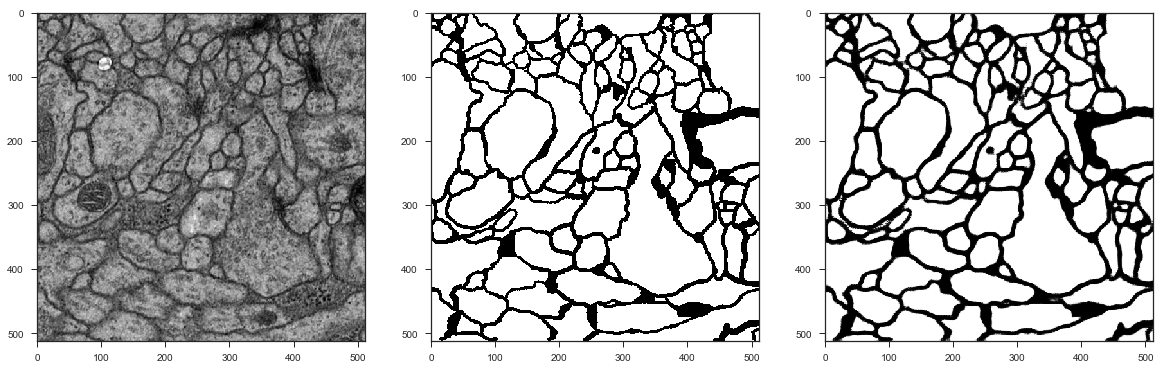

In [14]:
y_pred = model_unet_side_fuse.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

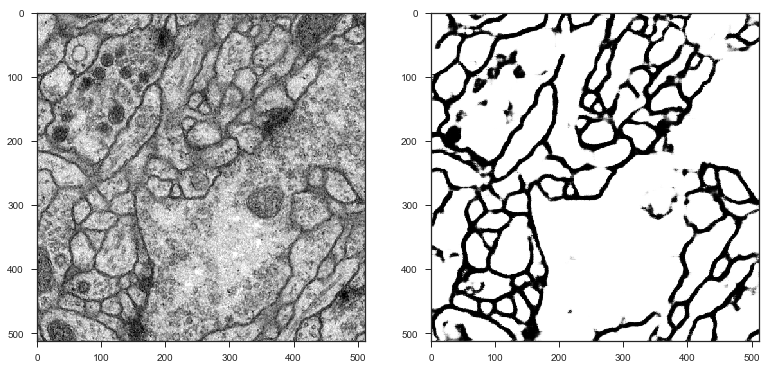

In [15]:
y_pred = model_unet_side_fuse.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()
